
# Trabalho Final de Sistemas de Recomendação (SCC0284)
### Prof. Marcelo Manzato

### Realizado por:

* Israel Felipe da Silva - 11796531

## Sobre o trabalho:
> Para o trabalho final da disciplina, o grupo decidiu fazer um **sistema de recomendação de livros** que utiliza o **SVD** como modelo. Foi utilizado um dataset contendo avaliações de livros por usuários e uma versão otimizada do SVD para gerar os fatores latentes, o que nos permite recomendar um conjunto de livros a partir dos padrões de interação do usuário.

In [41]:
import pandas as pd
import numpy as np
import wget
import random

## Leitura dos arquivos

In [42]:
# Arquivo de interações do dataset principal reduzido
data = pd.read_csv("https://raw.githubusercontent.com/israelfelipe9/Recomendador-de-livros/main/goodreads_interactions.csv")
data.head()

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0


### Hold Out

In [43]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=.2, random_state=2)

## Implementação SVD

In [44]:
# Obter a lista de todos os livros que um usuário avaliou.
def get_item_ids(df, user_id):
    if user_id not in df['user_id'].values:
        return []
    return (df.loc[(df.user_id==user_id),'book_id'].tolist())

get_item_ids(data, 0)

[948,
 947,
 946,
 945,
 944,
 943,
 942,
 941,
 940,
 939,
 938,
 937,
 936,
 935,
 934,
 933,
 932,
 931,
 930,
 929,
 928,
 927,
 926,
 925,
 924,
 923,
 922,
 921,
 920,
 919,
 918,
 917,
 916,
 915,
 914,
 913,
 912,
 911,
 910,
 909,
 908,
 907,
 906,
 905,
 904,
 903,
 902,
 901,
 900,
 899,
 898,
 897,
 896,
 895,
 894,
 893,
 892,
 891,
 890,
 889,
 888,
 887,
 886,
 885,
 884,
 883,
 882,
 881,
 880,
 879,
 878,
 877,
 876,
 875,
 874,
 873,
 872,
 871,
 870,
 869,
 868,
 867,
 866,
 865,
 864,
 863,
 862,
 861,
 860,
 859,
 858,
 857,
 856,
 855,
 854,
 853,
 852,
 851,
 850,
 849,
 848,
 847,
 846,
 845,
 844,
 843,
 842,
 841,
 840,
 839,
 838,
 837,
 836,
 835,
 834,
 833,
 832,
 831,
 830,
 829,
 828,
 827,
 826,
 825,
 824,
 823,
 822,
 821,
 820,
 819,
 818,
 817,
 816,
 815,
 814,
 813,
 812,
 811,
 810,
 809,
 808,
 807,
 806,
 805,
 804,
 803,
 802,
 801,
 800,
 799,
 798,
 797,
 796,
 795,
 794,
 793,
 792,
 791,
 790,
 789,
 788,
 787,
 786,
 785,
 784,
 783,
 782

In [45]:
observed = dict()
unobserved = dict()
all_users = data['user_id'].unique().tolist() # usar conj. total
all_items = data['book_id'].unique().tolist() # usar conj. total

for u in all_users:
    observed[u] = get_item_ids(train, u) # usar conj. de treinamento
    unobserved[u] = list(set(all_items)-set(observed[u]))

# Retorna um item visualizado pelo usuário e um não visualizado
def draw(user_id):    
    i = random.choice(observed[user_id])
    j = random.choice(unobserved[user_id])
    return i, j

draw(2)

(1135, 81110)

In [46]:
# Algoritmo SVD otimizado
from math import sqrt

def train_svdopt(train, n_factors, lr=0.05, reg=0.02, miter=10):
    global_mean = train['rating'].mean()
    n_users = data['user_id'].max()+1
    n_items = data['book_id'].max()+1
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))
    error = []
    for t in range(miter):
        sq_error = 0
        for index, row in train.iterrows():
            u = row['user_id']
            i = row['book_id']
            r_ui = row['rating']
            pred = global_mean + bu[u] + bi[i] + np.dot(p[u], q[i])
            e_ui = r_ui - pred
            sq_error = sq_error + pow(e_ui, 2)
            bu[u] = bu[u] + lr * e_ui
            bi[i] = bi[i] + lr * e_ui
            for f in range(n_factors):
                temp_uf = p[u][f]
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f] - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
        error.append(sqrt(sq_error/len(train)))
    
    return global_mean, bu, bi, p, q, error

In [47]:
gl, bu, bi, p, q, error = train_svdopt(train, 7, miter = 30)

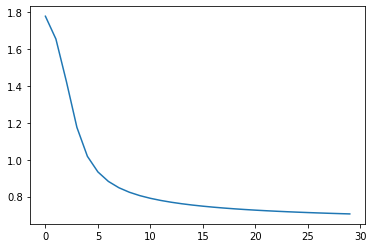

In [48]:
import matplotlib.pyplot as plt

plt.plot(err or)
plt.show()

In [49]:
# Gera as predições do SVD
def predictSVD(N=30):
    w = bi.T + np.dot(p, q.T)
    ranking = []
    
    for u, user in enumerate(all_users):
        partial_ranking = list()
        candidate_items = sorted(range(len(w[u])), key=lambda k: w[u][k], reverse=True)
        
        for i in candidate_items:
            if i not in observed[user]:
                partial_ranking.append((user, i, w[u][i]))

            if len(partial_ranking) == N:
                break

        ranking += partial_ranking
        
    return pd.DataFrame(ranking, columns=['user_id', 'book_id', 'score'])

In [50]:
# Predições geradas pelo SVD
rankingSVD = predictSVD()

In [51]:
def SVDRecommendation(user_id):
    return rankingSVD[rankingSVD['user_id'] == user_id]

SVDRecommendation(0)

,user_id,book_id,score
0,0,24424,8.426570
1,0,15364,8.395653
2,0,21897,7.775761
3,0,19077,7.435900
4,0,51259,7.343294
5,0,935,7.161511
6,0,1718,7.135914
7,0,17627,7.041202
8,0,15362,7.028576
9,0,1208,6.727329


## Implementação BPR

In [52]:
# ALgoritmo BPR com FunkSVD
def train_bprmf(train, n_factors, lr=0.05, reg=0.02, miter=30):    
    n_users = data['user_id'].max()+1
    n_items = data['book_id'].max()+1    
    item_bias = np.zeros(n_items)
    p = np.random.normal(0, 0.1, (n_users, n_factors))
    q = np.random.normal(0, 0.1, (n_items, n_factors))
    
    error = []
    for t in range(miter):
        #print('Iter #', t)
        sq_error = 0
        random_users = random.choices(train['user_id'].unique(), k=len(train))
        for u in random_users:
            i, j = draw(u)
            x_uij = item_bias[i] - item_bias[j] + (np.dot(p[u], q[i]) - np.dot(p[u], q[j]))
            sq_error += x_uij
            
            eps = 1 / (1 + np.exp(x_uij))

            item_bias[i] += lr * (eps - reg * item_bias[i])
            item_bias[j] += lr * (-eps - reg * item_bias[j])            

            # Adjust the factors
            u_f = p[u]
            i_f = q[i]
            j_f = q[j]

            # Compute and apply factor updates
            p[u] += lr * ((i_f - j_f) * eps - reg * u_f)
            q[i] += lr * (u_f * eps - reg * i_f)
            q[j] += lr * (-u_f * eps - reg * j_f)
            
        error.append(sq_error/len(random_users))
            
    return item_bias, p, q, error

In [53]:
b, p, q, error = train_bprmf(train, 4)

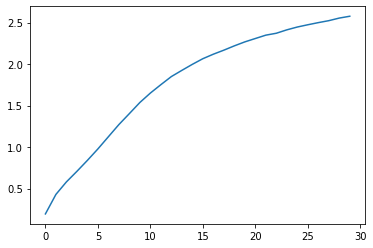

In [54]:
plt.plot(error)
plt.show()

In [55]:
# Gera as predições do BPR
def predictBPR(N=30):
    w = b.T + np.dot(p, q.T)
    ranking = []
    
    for u, user in enumerate(all_users):
        partial_ranking = list()
        candidate_items = sorted(range(len(w[u])), key=lambda k: w[u][k], reverse=True)
        
        for i in candidate_items:
            if i not in observed[user]:
                partial_ranking.append((user, i, w[u][i]))

            if len(partial_ranking) == N:
                break

        ranking += partial_ranking
        
    return pd.DataFrame(ranking, columns=['user_id', 'book_id', 'score'])
    

In [56]:
# Predições geradas pelo BPR
rankingBPR = predictBPR()

In [57]:
def BPRRecommendation(user_id):
    return rankingBPR[rankingBPR['user_id'] == user_id]

BPRRecommendation(0)

,user_id,book_id,score
0,0,677,4.112000
1,0,13565,4.002308
2,0,12981,3.999629
3,0,8425,3.945309
4,0,999,3.912645
5,0,13099,3.908816
6,0,13413,3.898947
7,0,1210,3.892561
8,0,7406,3.879320
9,0,7239,3.878254


In [58]:
def Precision(user_id, ndf):
    # Conjunto de itens recomendados ao usuário (SVD ou BPR)
    recs_user = ndf.loc[(ndf.user_id==user_id), 'book_id'].tolist()
    # Conjunto relevante (itens do conjunto de teste que o usuaário gostou)
    ground_truth = test.loc[(test.user_id==user_id) & (test.rating > 2), 'book_id'].tolist()
    # Itens Recomendados E relevantes do conjunto de teste
    intersec = list(set(recs_user) & set(ground_truth))
    return len(intersec)

In [59]:
# Printa para cada usuário o quanto cada algoritmo conseguiu recomendar de itens
# do conjunto de teste que de fato o usuário gostou
for i in range(0, 50):
    print("Usuário ", i, "\tSVD: ", Precision(i, rankingSVD), "\tBPR: ", Precision(i, rankingBPR))

Usuário  0 	SVD:  1 	BPR:  1
Usuário  1 	SVD:  0 	BPR:  0
Usuário  2 	SVD:  0 	BPR:  3
Usuário  3 	SVD:  0 	BPR:  0
Usuário  4 	SVD:  0 	BPR:  2
Usuário  5 	SVD:  0 	BPR:  2
Usuário  6 	SVD:  0 	BPR:  0
Usuário  7 	SVD:  0 	BPR:  1
Usuário  8 	SVD:  0 	BPR:  1
Usuário  9 	SVD:  0 	BPR:  2
Usuário  10 	SVD:  0 	BPR:  0
Usuário  11 	SVD:  0 	BPR:  0
Usuário  12 	SVD:  0 	BPR:  2
Usuário  13 	SVD:  0 	BPR:  4
Usuário  14 	SVD:  1 	BPR:  0
Usuário  15 	SVD:  0 	BPR:  2
Usuário  16 	SVD:  0 	BPR:  2
Usuário  17 	SVD:  0 	BPR:  2
Usuário  18 	SVD:  0 	BPR:  1
Usuário  19 	SVD:  0 	BPR:  1
Usuário  20 	SVD:  1 	BPR:  0
Usuário  21 	SVD:  0 	BPR:  0
Usuário  22 	SVD:  0 	BPR:  3
Usuário  23 	SVD:  0 	BPR:  0
Usuário  24 	SVD:  1 	BPR:  1
Usuário  25 	SVD:  0 	BPR:  0
Usuário  26 	SVD:  0 	BPR:  3
Usuário  27 	SVD:  0 	BPR:  2
Usuário  28 	SVD:  0 	BPR:  1
Usuário  29 	SVD:  0 	BPR:  8
Usuário  30 	SVD:  0 	BPR:  2
Usuário  31 	SVD:  0 	BPR:  4
Usuário  32 	SVD:  0 	BPR:  1
Usuário  33 	SVD:  0

## Resultados Obtidos

> Como podemos analisar nos resultados obtidos, a base de dados contém um número elevado de itens, com isso, os algoritmos acabam gerando recomendações considerando todos estes itens, oque visualmente não temos como facilmente confirmar que é uma recomendação eficiente. Apesar disso, conseguimos notar que com o algoritmo recomendando 30 itens para cada usuário, ja conseguirmos obter resultados interessantes, onde, para alguns casos o algoritmo recomendou itens que de fato o usuário gostou.

> Além disso, fica muito claro que o algoritmo BPR conseguiu em sua grande maioria ser mais preciso nas recomendações. Isto ja era esperado, é natural que o BPR tenha um desempenho melhor. O SVD otimizado dá o rating e tenta aproximar a nota durante o treinamento, usando fatoração de matriz para isso. O BPR-MF usa a mesma fatoração de matriz, mas tenta garantir a ordem (ranqueamento) dos itens, sem se preocupar com a nota, resultando naturalmente numa recomendação mais eficiente.

## Oportunidades de trabalhos futuros

> O UCSD fornece arquivos separando os livros por gêneros e arquivos contendo os meta-dados dos livros, isso se torna uma possibilidade para um trabalho futuro até mesmo envolvendo o uso do SVD ou BPR, com por exemplo uma abordagem híbrida entre os algoritmos trabalhando os meta-dados.

> O site fornece também um arquivo contendo as Reviews em texto que usuários da base deram para determinados itens, isso abre possibilidade para se trabalhar técnicas de processamento de linguagem natural, para extração de características dos textos e usar tais informações nas recomendações.

# Referências:

*   Dataset: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home?pli=1
*   PDF Aula 02 de Sistemas de Recomendação, Marcelo Manzato

*   PDF Aula 08 de Sistemas de Recomendação, Marcelo Manzato
*   Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18
* Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19.

